In [1]:
# ref detector: https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49
# ref rotation: https://www.kaggle.com/code/gpiosenka/align-crop-resize-save-images-using-mtcnn

import os
import sys

sys.path.append('../tflow/mtcnn')

import cv2
import numpy as np
from tqdm import tqdm
from utils import load_image
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from imutils.paths import list_images

In [2]:
dataset = '/home/choppy/TOC/datasets/LFW/archive/lfw-deepfunneled/lfw-deepfunneled'
dst_dataset = 'cropped_aligned_LFW'

images = [*list_images(dataset)]
len(images)

13233

In [3]:
# check if it works
image_path = images[19]
img = load_image(image_path)
detector = MTCNN()
detections = detector.detect_faces(img)
detections

2022-09-13 13:26:16.868018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 13:26:16.894486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 13:26:16.894894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 13:26:16.895520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

[{'box': [90, 80, 74, 101],
  'confidence': 0.999299168586731,
  'keypoints': {'left_eye': (109, 113),
   'right_eye': (142, 117),
   'nose': (121, 135),
   'mouth_left': (108, 154),
   'mouth_right': (133, 157)}}]

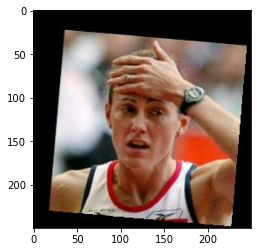

In [4]:
plt.imshow(img)

In [5]:
def align(img, data):
    # In case the image has more than 1 face, find the biggest face
    biggest=0
    if data != []:
        for faces in data:
            box = faces['box']            
            # calculate the area in the image
            area = box[3]  * box[2]
            if area > biggest:
                biggest = area
                bbox = box                
                keypoints = faces['keypoints']
                left_eye = keypoints['left_eye']
                right_eye = keypoints['right_eye']                 
        
        lx,ly = left_eye        
        rx,ry = right_eye
        dx = rx-lx
        dy = ry-ly
        tan = dy/dx
        theta = np.arctan(tan)
        theta = np.degrees(theta)    
        img = rotate_bound(img, theta)        
        return img
    
    else:
        return None

In [6]:
def crop_image(img, data): 
    
    #y=box[1] h=box[3] x=box[0] w=box[2]   
    biggest=0
    
    if data != []:
        for faces in data:
            box = faces['box']            
            # calculate the area in the image
            area = box[3] * box[2]
            if area > biggest:
                biggest = area
                bbox = box 
        bbox[0] = 0 if bbox[0] < 0 else bbox[0]
        bbox[1] = 0 if bbox[1] < 0 else bbox[1]
        img = img[ bbox[1]: bbox[1] + bbox[3], bbox[0]: bbox[0] + bbox[2] ]
        return img
    else:
        return None

def rotate_bound(image, angle):
    # rotates an image by the degree angle
    # grab the dimensions of the image and then determine the center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1]) 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin)) 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH)) 

In [7]:
_crop = crop_image(load_image(image_path), detections)
aligned = align(_crop, detections)

In [8]:
image_path

'/home/choppy/TOC/datasets/LFW/archive/lfw-deepfunneled/lfw-deepfunneled/Hayley_Tullett/Hayley_Tullett_0002.jpg'

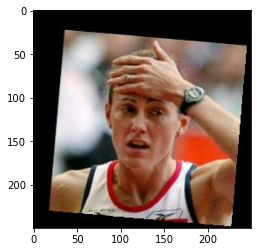

In [9]:
plt.imshow(load_image(image_path))

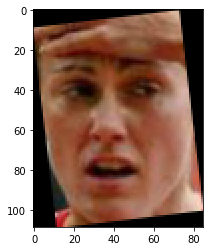

In [10]:
plt.imshow(aligned)

In [16]:
os.makedirs(dst_dataset, exist_ok=True)

for imdir in tqdm(images):
    img = load_image(imdir)
    detections = detector.detect_faces(img)
    
    if detections:
        _crop = crop_image(img, detections)
        aligned = align(_crop, detections)

        name_info = imdir.split(dataset)[-1][1:]
        name_info_dirname = os.path.dirname(name_info)
        os.makedirs(os.path.join(dst_dataset, name_info_dirname), exist_ok=True)

        aligned_bgr = cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dst_dataset, name_info), aligned_bgr)
    else:
        # save image as is
        name_info = imdir.split(dataset)[-1][1:]
        name_info_dirname = os.path.dirname(name_info)
        os.makedirs(os.path.join(dst_dataset, name_info_dirname), exist_ok=True)
        cv2.imwrite(os.path.join(dst_dataset, name_info), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13233/13233 [1:05:59<00:00,  3.34it/s]
